In [2]:
import json 
import matplotlib.pyplot as plt
import urllib.request
from datetime import datetime
from math import exp,floor
import numpy as np
from scipy.integrate import odeint #Va nous permettre de résoudre des équations différentielles
from scipy.optimize import leastsq,least_squares,curve_fit #Importation de la méthode des moindres carrés
import scipy.stats as stats


url="https://www.data.gouv.fr/fr/datasets/r/a7596877-d7c3-4da6-99c1-2f52d418e881"
response = urllib.request.urlopen(url)
covid_dict= json.loads(response.read())

#with open('dataCovid.txt', 'r') as dataDumpFile:
#	covid_dict= json.loads(dataDumpFile.read())

#with open('dataCovid.txt', 'w') as dataDumpFile:
#    json.dump(covid_dict, dataDumpFile)


coeffDeces= [8.85124505 8.59601971 0.13699897]


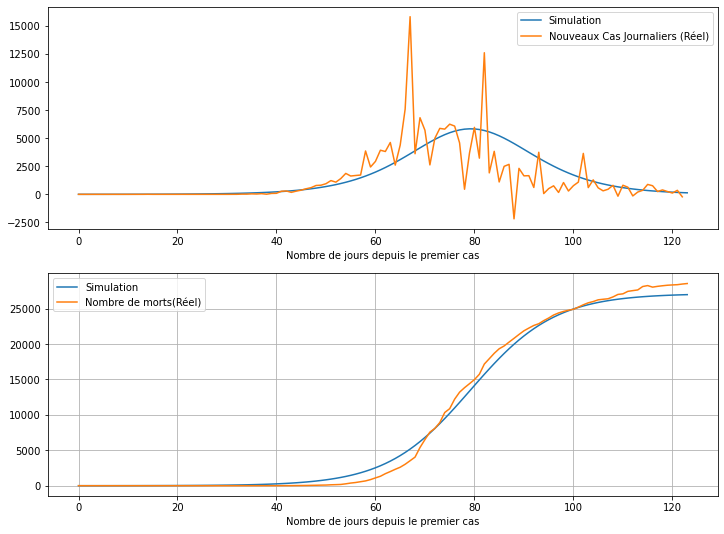

In [4]:
def derivee(tableau,dx):
    return np.diff(tableau)/dx

def recup_pays(pays):
    sortie=[]
    if pays=="Monde": #Possibilité de considérer le "monde" comme un pays
        sortie=[donnee for donnee in covid_dict['GlobalData']]
    else :
        sortie= [donnee for donnee in covid_dict['PaysData'] if donnee['Pays']==pays]
    sortie.reverse()
    return sortie

def recup_champ(table,champ):
    sortie= [donnee[champ] for donnee in table] #Fonction servant à simplifier les écritures
    #sortie.reverse()
    return sortie
    
    
def SIRD(beta,gamma,mu,t):
    #Ic : nombre de personnes contagieuses
    #Wc : nombre de personnes infectées
    #L : nombre de personnes infectées isolées qui mourront sans infecter d'autres personnes
    #D : nombre de personnes mortes

	N=65e6				#Population Française
	initiale=[N-2,2,0,0]			#Variable non tronquée : deux infections au départ
    
    #conditions_initiales=np.array(initial,dtype='float64')

	def modele(y,t1):
		S, I, R, D = y
        
		d_S = -beta*I*S/N
		d_I = beta*I*S/N-gamma*I-mu*I
		d_R = gamma*I
		d_D = mu*I
        
		return np.array([d_S,d_I,d_R,d_D],dtype='float64')
    
	y = odeint(modele,initiale,t)
    
	return np.transpose(y)

def cout(param, tablemorts,tableinfections): #fonction de cout pour le modele SIRD
	t=np.arange(len(tablemorts))
	S,I,R,D = SIRD(param[0],param[1],param[2],t)
	return tablemorts[:-1]-D[:-1] + derivee(tableinfections,1)-I[:-1]			#Petite modif, on optimise sur les décès et la DERIVEE du nombre d'infectés réels


table_France=recup_pays("France")

Table_infection = recup_champ(table_France,'Infection')

Table_deces= recup_champ(table_France,'Deces')


#y=recup_champ(table_France,'Infection')
#x=range(len(y))
#y2=recup_champ(table_France,'Deces')


#plt.plot(x,y,y2)
#plt.grid()
#plt.show()

#t = np.linspace(0,100)
#verif=SIRD(0.4,0.035,0.005,t)

#plt.plot(t,verif)
#plt.grid()
#plt.show()

#residu=cout([0.4,0.035,0.005],Table_deces)

#print(residu)
plt.rcParams['figure.figsize'] = [12, 9]
coeffDeces, flagDeces = leastsq(cout, [0.4,0.035,0.005], args=(Table_deces,Table_infection))
print('coeffDeces=',coeffDeces)
#print(coeffDeces)
t=np.arange(len(Table_deces))	
S,I,R,D=SIRD(coeffDeces[0],coeffDeces[1],coeffDeces[2],t)

plt.subplot(211)
plt.plot(t,I,label='Simulation')
plt.plot(t[:-1],derivee(Table_infection,1),label='Nouveaux Cas Journaliers (Réel)')
plt.grid
plt.legend()
plt.xlabel('Nombre de jours depuis le premier cas')

plt.subplot(212)
plt.plot(t,D,label='Simulation')
plt.plot(t,Table_deces,label='Nombre de morts(Réel)')
plt.legend()
plt.grid()
plt.xlabel('Nombre de jours depuis le premier cas')
plt.show()


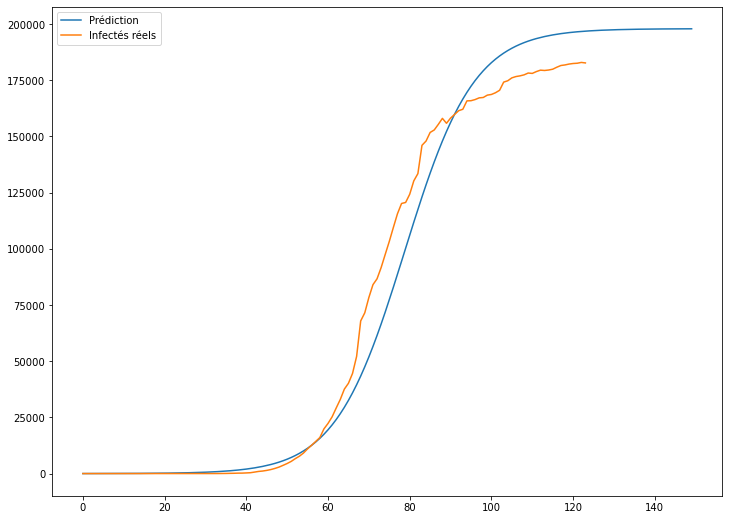

In [5]:
def integrale_degueu(tableau): # mon prof de maths me cracherait dessus s'il voyait ça mais bon , tant que ça marche...
    out=[tableau[0]]
    s=tableau[0]
    for elem in tableau[1:]:
        s+=elem
        out.append(s)
    return out
S,I,R,D=SIRD(coeffDeces[0],coeffDeces[1],coeffDeces[2],np.arange(150))
plt.plot(np.arange(150),integrale_degueu(I),label='Prédiction')
plt.plot(t,Table_infection, label='Infectés réels')
plt.legend()
# Effectivement il semblerait que le I attendu par le modèle SIRD soit bel et bien la dérivée du nombre d'infectés totaux

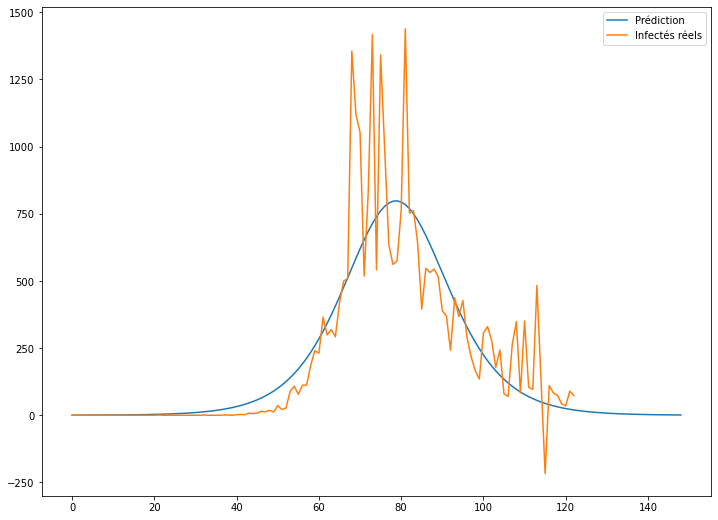

In [8]:
plt.plot(np.arange(150)[:-1],derivee(D,1),label='Prédiction')
plt.plot(t[:-1],derivee(Table_deces,1), label='Infectés réels')
plt.legend()